<a href="https://colab.research.google.com/github/appsstuff/006962/blob/master/Smart_Autoscaling_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
print(np.__version__)

2.0.2


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# ---------- Load real dataset or fallback ----------
file_path = "usask.sec.min.xlsx"

df = None  # Initialize

try:
    df = pd.read_excel(file_path)
    df.columns = df.columns.str.strip()  # Clean column names

    # Validate columns
    required_columns = {"Time_minute", "TotalNoOfComingRequests"}
    if not required_columns.issubset(set(df.columns)):
        raise ValueError(f"❌ Missing required columns. Found: {list(df.columns)}")

    print("✅ Loaded real dataset.")
    print(df.head())

except FileNotFoundError:
    print("⚠️ File not found:", file_path)
except ValueError as ve:
    print("❌ Validation Error:", ve)
except Exception as e:
    print("❌ Unexpected error:", e)

✅ Loaded real dataset.
   Time_minute  TotalNoOfComingRequests
0            1                      100
1            2                      100
2            3                      100
3            4                      200
4            5                      200


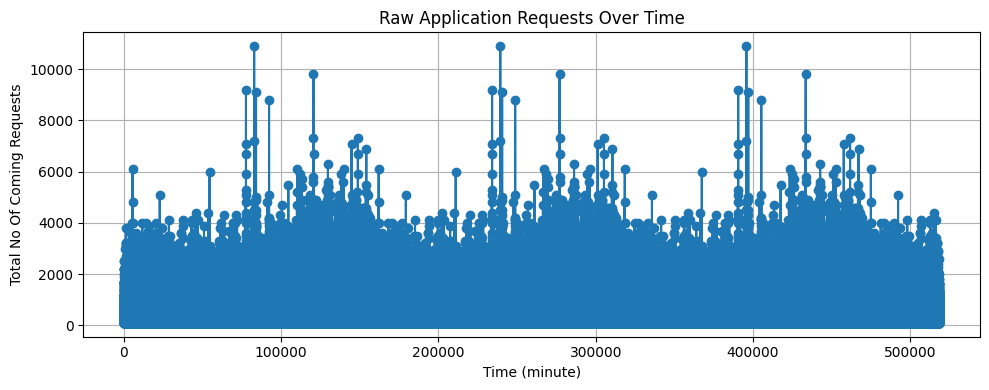

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]


Epoch 1: val_loss improved from inf to 0.00319, saving model to training_checkpoints/model_epoch_01_val_loss_0.0032.keras

Epoch 2: val_loss did not improve from 0.00319

Epoch 3: val_loss improved from 0.00319 to 0.00319, saving model to training_checkpoints/model_epoch_03_val_loss_0.0032.keras

Epoch 4: val_loss did not improve from 0.00319

Epoch 5: val_loss improved from 0.00319 to 0.00309, saving model to training_checkpoints/model_epoch_05_val_loss_0.0031.keras

Epoch 6: val_loss did not improve from 0.00309

Epoch 7: val_loss improved from 0.00309 to 0.00308, saving model to training_checkpoints/model_epoch_07_val_loss_0.0031.keras

Epoch 8: val_loss did not improve from 0.00308

Epoch 9: val_loss did not improve from 0.00308

Epoch 10: val_loss improved from 0.00308 to 0.00307, saving model to training_checkpoints/model_epoch_10_val_loss_0.0031.keras

Epoch 11: val_loss did not improve from 0.00307

Epoch 12: val_loss did not improve from 0.00307

Epoch 13: val_loss did not im

In [ ]:
# ---------- Plot raw data ----------
if df is not None:
    try:
        plt.figure(figsize=(10, 4))
        plt.plot(df["Time_minute"], df["TotalNoOfComingRequests"], marker='o')
        plt.title("Raw Application Requests Over Time")
        plt.xlabel("Time (minute)")
        plt.ylabel("Total No Of Coming Requests")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as plot_error:
        print("❌ Plotting Error:", plot_error)

# ---------- Normalize data ----------
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[["Time_minute", "TotalNoOfComingRequests"]])

# ---------- Prepare sliding window data ----------
X, y = [], []
window_size = 20
for i in range(len(scaled_data) - window_size):
    X.append(scaled_data[i:i+window_size, 0].reshape(-1, 1))  # time windows reshaped for LSTM
    y.append(scaled_data[i+window_size, 1])                   # request count at next point

X = np.array(X)
y = np.array(y)

# ---------- Train/test split ----------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------- Build LSTM model ----------
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(window_size, 1)),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# ---------- Set up checkpointing ----------
import os
from tqdm.keras import TqdmCallback
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_dir = 'training_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}_val_loss_{val_loss:.4f}.keras'),
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    save_weights_only=False,
    verbose=1
)

# ---------- Train the model ----------
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    verbose=0,
    callbacks=[TqdmCallback(verbose=1), checkpoint_callback]
)

# ---------- Evaluate the model ----------
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Final Evaluation:\nLoss (MSE): {loss:.6f}\nMean Absolute Error (MAE): {mae:.6f}")

# ---------- Plot training history ----------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# ---------- Evaluation table: Predictions vs Actual ----------
# Predict on test set
y_pred_scaled = model.predict(X_test)

# Create an array of dummy timestamps to inverse transform
dummy_time = np.zeros((len(y_test), 1))
y_test_scaled = np.column_stack((dummy_time, y_test))
y_pred_scaled_full = np.column_stack((dummy_time, y_pred_scaled.reshape(-1)))

# Inverse transform
y_test_original = scaler.inverse_transform(y_test_scaled)[:, 1]
y_pred_original = scaler.inverse_transform(y_pred_scaled_full)[:, 1]

# Create DataFrame
results_df = pd.DataFrame({
    "Actual Requests": y_test_original.astype(int),
    "Predicted Requests": y_pred_original.astype(int)
})

# Show evaluation table
print("\n📊 Evaluation Table (Actual vs. Predicted):")
print(results_df.head(10))  # Show first 10 predictions


In [ ]:

# ---------- Evaluation table: Predictions vs Actual ----------
y_pred_scaled = model.predict(X_test)

# Create an array of dummy timestamps to inverse transform
dummy_time = np.zeros((len(y_test), 1))
y_test_scaled = np.column_stack((dummy_time, y_test))
y_pred_scaled_full = np.column_stack((dummy_time, y_pred_scaled.reshape(-1)))

# Inverse transform
y_test_original = scaler.inverse_transform(y_test_scaled)[:, 1]
y_pred_original = scaler.inverse_transform(y_pred_scaled_full)[:, 1]

# Create DataFrame
results_df = pd.DataFrame({
    "Actual Requests": y_test_original.astype(int),
    "Predicted Requests": y_pred_original.astype(int)
})

# Show evaluation table
print("\n📊 Evaluation Table (Actual vs. Predicted):")
print(results_df.head(10))


3240/3240 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step

📈 Final Model Evaluation:
🔹 Mean Squared Error (MSE): 0.003073
🔹 Mean Absolute Error (MAE): 0.040272
🔹 R² Score: 0.050502


In [ ]:
# Define a threshold accuracy: % of predictions within X% of true value
tolerance = 0.1  # 10%
accurate_preds = np.abs(y_pred_inv - y_test_inv) / y_test_inv < tolerance
custom_accuracy = np.mean(accurate_preds) * 100

print(f"🔹 Custom Accuracy (within ±10%): {custom_accuracy:.2f}%")



🔹 Custom Accuracy (within ±10%): 10.22%
